In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

#%matplotlib inline

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def reshape_and_normalize(data):
    data = data.reshape([-1, 1024, 3], order='F')
    data = data.reshape([-1, 32, 32, 3], order='C') 
    data = data / 255
    return data
    

Using TensorFlow backend.


In [2]:
# Data downloaded from - https://www.cs.toronto.edu/~kriz/cifar.html


# Load Train data
data = unpickle('data/data_batch_1')
train_X = data[b'data']
train_y = data[b'labels']

for i in range (2, 6):
    data = unpickle('data/data_batch_{:s}'.format(str(i)))
    train_X = np.concatenate((train_X, data[b'data']), axis=0) 
    train_y = np.concatenate((train_y, data[b'labels']), axis=0) 
    
train_X = reshape_and_normalize(train_X)
train_y = to_categorical(train_y, num_classes=10)

# Create validation set
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size = 0.25, random_state=1)


# Load Test data
data = unpickle('data/test_batch')
test_X = data[b'data']
test_y = data[b'labels']

test_X = reshape_and_normalize(test_X)
test_y = to_categorical(test_y, num_classes=10)
    
meta = unpickle('data/batches.meta')
classes = [l.decode('ascii') for l in meta[b'label_names']]


print('Training   set: {}'.format(train_X.shape))
print('Validation set: {}'.format(valid_X.shape))
print('Test       set: {}'.format(test_X.shape))

Training   set: (37500, 32, 32, 3)
Validation set: (12500, 32, 32, 3)
Test       set: (10000, 32, 32, 3)


In [3]:
### Peaking at the cifar10 images

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(331 + i)
    plt.title(classes[train_y[i].argmax()])
    plt.imshow(train_X[i]);

In [4]:
# Image Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #shear_range=0.5
    #rotation_range=10,
    #zoom_range=0.2,
    #width_shift_range=0.5,
    #height_shift_range=0.5,
    #horizontal_flip=True,
    #vertical_flip=True
)

datagen.fit(train_X)

In [5]:
# Build Model
from keras.layers import MaxPool2D, Conv2D, Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, InputLayer, AveragePooling2D, Activation
from keras.models import Sequential


NETWORK = 1

model = Sequential()
model.add(InputLayer(input_shape=(32, 32, 3)))
    
if NETWORK == 0:
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    
elif NETWORK == 1:
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.5))
    
    model.add(Conv2D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Dropout(rate=0.4))
    
    model.add(Conv2D(filters=512, kernel_size=1, strides=1, activation='relu', padding='same'))
    model.add(Dropout(rate=0.3))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
model.add(Dense(10, activation='softmax'))

from keras.optimizers import RMSprop, Adam, Adamax
opt = Adamax()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
__________

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  

epochs = 200

checkpointer = ModelCheckpoint(filepath=f'saved_models/network{NETWORK}.weights.best.hdf5', 
                               verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

### Train with raw data ###
#model.fit(train_X, train_y, 
#          validation_data=(valid_X, valid_y),
#          epochs=epochs, batch_size=20, callbacks=[checkpointer, earlystopper], verbose=0)

### Train with augmented data ###
model.fit_generator(datagen.flow(train_X, train_y, batch_size=20),
                    validation_data=(valid_X, valid_y),
                    steps_per_epoch=len(train_X) / 20, epochs=epochs, callbacks=[checkpointer, earlystopper], verbose=0)

Epoch 00000: val_loss improved from inf to 2.30265, saving model to saved_models/network1.weights.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 2.30265 to 2.30264, saving model to saved_models/network1.weights.best.hdf5
Epoch 00003: val_loss improved from 2.30264 to 2.30263, saving model to saved_models/network1.weights.best.hdf5
Epoch 00004: val_loss improved from 2.30263 to 1.60425, saving model to saved_models/network1.weights.best.hdf5
Epoch 00005: val_loss improved from 1.60425 to 1.36356, saving model to saved_models/network1.weights.best.hdf5
Epoch 00006: val_loss improved from 1.36356 to 1.10773, saving model to saved_models/network1.weights.best.hdf5
Epoch 00007: val_loss improved from 1.10773 to 1.00816, saving model to saved_models/network1.weights.best.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 1.00816 to 0.87536, saving model to saved_models/network1.weights.best.hdf5
Epoch 00010: val_loss improved f

In [1]:
model.load_weights(f'saved_models/network{NETWORK}.weights.best.hdf5')

train_y_hat = model.predict(train_X)
print('Training   Accuracy: {:.4f}%'.format(100*np.mean(np.argmax(train_y_hat, axis=1) == np.argmax(train_y, axis=1))))

valid_y_hat = model.predict(valid_X)
print('Validation Accuracy: {:.4f}%'.format(100*np.mean(np.argmax(valid_y_hat, axis=1) == np.argmax(valid_y, axis=1))))

test_y_hat = model.predict(test_X)
print('Test       Accuracy: {:.4f}%'.format(100*np.mean(np.argmax(test_y_hat, axis=1) == np.argmax(test_y, axis=1))))

NameError: name 'model' is not defined

In [9]:
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
import cv2     
from keras.preprocessing import image    
from keras.models import Model   
import sys

def pretrained_path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(32, 32))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    # convert RGB -> BGR, subtract mean ImageNet pixel, and return 4D tensor
    #return preprocess_input(x)
    return x

#model, all_amp_layer_weights = get_ResNet()
# Get weights
last_cnn_layer = -5
output_layer = -1
new_model = Model(inputs=model.input, outputs=(model.layers[last_cnn_layer].output, model.layers[output_layer].output)) 
all_amp_layer_weights = model.layers[output_layer].get_weights()[0]


#img_path = 'images/ship_dog.jpg'
#img_path = 'images/dog_download.png'
img_path = 'images/ship_download.png'
#img_path = 'images/ship1.png'
fig, ax = plt.subplots()

# load image, convert BGR --> RGB, resize image to 224 x 224,
im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (32, 32))
# plot image
ax.imshow(im, alpha=0.5)
# get class activation map

In [10]:
# get filtered images from convolutional output + model prediction vector
last_conv_output, pred_vec = new_model.predict(pretrained_path_to_tensor(img_path))
# change dimensions of last convolutional output to 4 x 4 x 512
last_conv_output = np.squeeze(last_conv_output) 

pred = np.argmax(pred_vec)

# bilinear upsampling to resize each filtered image to size of original image 
mat_for_mult = scipy.ndimage.zoom(last_conv_output, (8, 8, 1), order=1) # dim: 32 x 32 x 512
# get AMP layer weights
amp_layer_weights = all_amp_layer_weights[:, pred] # dim: (2048,) 
# get class activation map for object class that is predicted to be in the image
CAM = np.dot(mat_for_mult.reshape((32*32, 512)), amp_layer_weights).reshape(32,32) # dim: 224 x 224

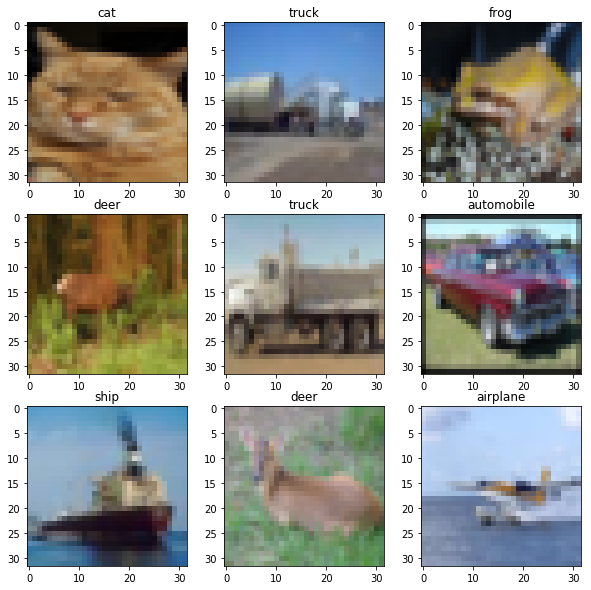

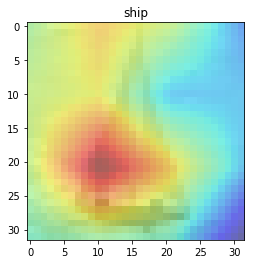

In [11]:
# load image, convert BGR --> RGB, resize image to 224 x 224,
im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (32, 32))
# plot image
ax.imshow(im, alpha=0.5)
# get class activation map
#CAM, pred = ResNet_CAM(img_path, model, all_amp_layer_weights)
# plot class activation map
ax.imshow(CAM, cmap='jet', alpha=0.5)

# obtain the predicted ImageNet category
ax.set_title(classes[pred])  
plt.show()

In [19]:
pred_vec

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]], dtype=float32)

In [15]:
classes[np.argmax(pred_vec)]

'cat'

In [16]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
amp_layer_weights.shape

In [8]:
model.layers[-1].output

<tf.Tensor 'dense_1/Softmax:0' shape=(?, 10) dtype=float32>

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
__________